### Handle Outliers using Winsorizer, Arbitrary capper or Outlier Trimmer

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.pipeline import Pipeline

## Handle Outlier

These techniques aim to cap outliers based on a calculation or an arbitrary value. In addition, you may drop the outliers from the dataset. It is important to use the business context to manage outliers. For example:
* If your variable is Age and you see a value of 400, that may mean an error when collecting the data. You may cap the outlier with a `Q3 + 1.5 * IQR` value, replace it with an arbitrary number, or drop the row. The practical decision depends on your business context. Luckily we can code and check the effect of multiple possibilities before deciding the most suitable option to handle the outlier.

We should consider it as the last option to drop rows containing outliers since the data collection process requires energy, time and money from some team, either your team or another team. Also, outliers may indicate that your data is changing its behaviour and that you have collected the first samples of this new behaviour.

We will study the following transformers
* Winsorizer
* ArbitraryOutlierCapper
* OutlierTrimmer

### Winsorizer

**What it does:**
* Replaces extreme values (outliers) with the nearest value within a specified limit instead of removing them.

**How it works:**
* You define thresholds, usually based on percentiles or IQR (Interquartile Range).
* Values above the upper limit are capped to the upper threshold.
* Values below the lower limit are capped to the lower threshold.
**Example (quantile-based):**

* If you use 5th and 95th percentiles:
* Values below the 5th percentile are replaced with the 5th percentile value.
* Values above the 95th percentile are replaced with the 95th percentile value.

**Pros:**
* Keeps all data points (no rows are dropped).
* Preserves the structure and size of the data.

**Cons:**
* Distorts the actual values of outliers.
* May not be suitable if exact values matter (e.g., in some scientific analyses).


It caps the outliers as a continuous variable's maximum and/or minimum values. It calculates the capping values using specific methods. The documentation is found [here](https://feature-engine.trainindata.com/en/latest/user_guide/outliers/Winsorizer.html)
* The arguments are the variables with outliers you are interested in (if you don't parse anything, it will consider all numerical variables).
    * `tail`, where you decide to cap outliers on the right, left or both tails.
    * `fold`, the number that will multiply the inter-quartile range (IQR) to calculate the capping values. The documentation says the recommended values are 1.5 or 3 for the IQR proximity rule.
    * `capping_method`; we will consider  `'iqr'`: 75th quantile + 1.5* IQR for the right tail and 25th quantile - 1.5* IQR for the left tail.

In [7]:
from feature_engine.outliers import Winsorizer

In [13]:
df = pd.read_csv('insurance.csv').filter(['bmi', 'expenses'])
print(df.shape)
df.head()

(1338, 2)


,bmi,expenses
0,27.9,16884.92
1,33.8,1725.55
2,33.0,4449.46
3,22.7,21984.47
4,28.9,3866.86


We will assess variable distribution with a custom function by plotting a combined histogram and a boxplot. We developed code to inform of the limits where the boxplot considers a data point an outlier (we calculate the [IQR](https://en.wikipedia.org/wiki/Interquartile_range) and the lower (Q1 - 1.5 x IRQ) and upper limits (Q3 + 1.5 x IQR) of the boxplot

Let's comment on the plots in terms of outliers:
* `bmi` has few outliers on the right side of the tail (or on the right side of the plot)
* `expenses` has multiple outliers on the right side of the tail.


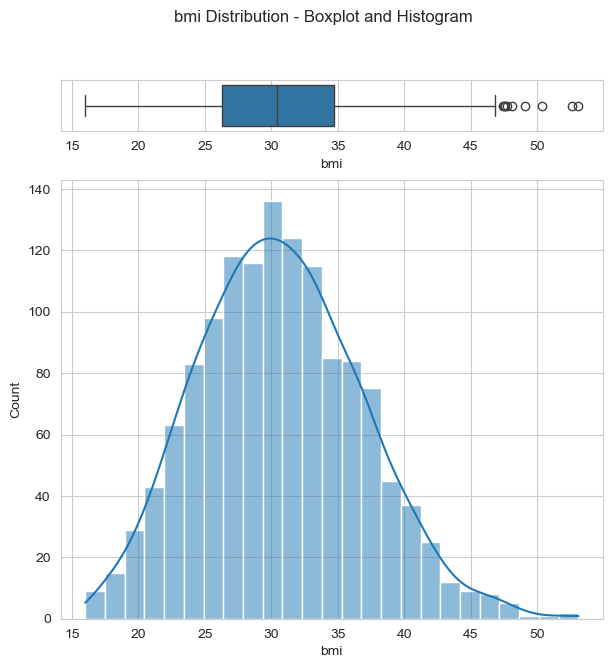

This is the range where a data point is not an outlier: from 13.7 to 47.3




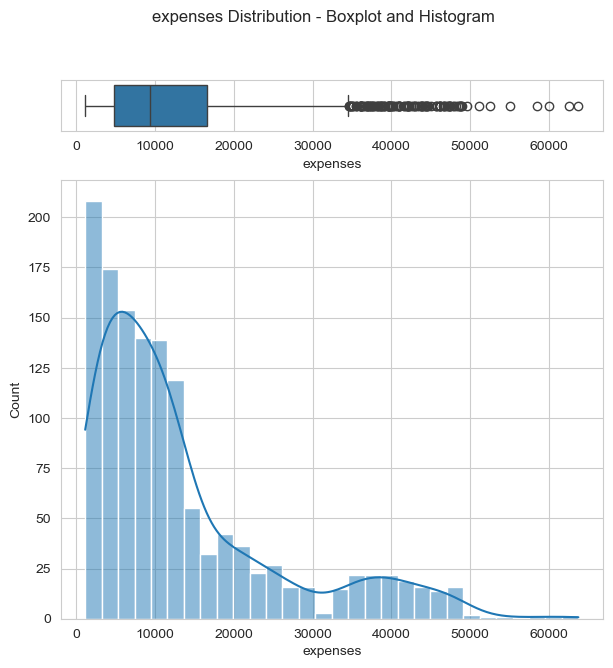

This is the range where a data point is not an outlier: from -13109.15 to 34489.36




In [18]:
def plot_histogram_and_boxplot(df):
  for col in df.columns:
    fig, axes = plt.subplots(nrows=2 ,ncols=1 ,figsize=(7,7), gridspec_kw={"height_ratios": (.10, .85)})
    sns.boxplot(data=df, x=col, ax=axes[0])
    sns.histplot(data=df, x=col, kde=True, ax=axes[1])
    fig.suptitle(f"{col} Distribution - Boxplot and Histogram")
    plt.show()

    IQR = df[col].quantile(q=0.75) - df[col].quantile(q=0.25)
    print(
        f"This is the range where a data point is not an outlier: from "
        f"{(df[col].quantile(q=0.25) - 1.5*IQR).round(2)} to "
        f"{(df[col].quantile(q=0.75) + 1.5*IQR).round(2)}")
    print("\n")

plot_histogram_and_boxplot(df)

We create a pipeline with two steps: ``DropMissingData()`` (since there should be no missing data),  ``then Winsorizer()``, on both variables using iqr as the capping method and fold as 1.5 on both tails.

`capping_method='iqr'`: This method uses the Interquartile Range (IQR) to identify and cap extreme values. The IQR is the range between the first (25th percentile) and third (75th percentile) quartiles in the data. Anything outside a certain range of this IQR can be considered an outlier.

`fold=1.5`: This defines how far from the IQR values are considered outliers. In this case, 1.5 times the IQR is used. Any data point beyond this threshold (either lower or higher) is considered extreme and will be "winsorized" (capped).

In [25]:
from feature_engine.imputation import DropMissingData
pipeline = Pipeline([
      ('drop_na', DropMissingData() ),
      ('winsorizer_iqr', Winsorizer(capping_method='iqr', fold=1.5, tail='both', variables=['bmi', 'expenses']) )
])

df_transformed = pipeline.fit_transform(df)
df_transformed.head()

,bmi,expenses
0,27.9,16884.92
1,33.8,1725.55
2,33.0,4449.46
3,22.7,21984.47
4,28.9,3866.86


Note the **capping points** change when you apply iqr. We assess the cap values with `.right_tail_caps` and `.left_tail_caps`. We first check the right tails cap

In [27]:
pipeline['winsorizer_iqr'].right_tail_caps_

{'bmi': 47.300000000000004, 'expenses': 34489.35625}

In [30]:
pipeline['winsorizer_iqr'].left_tail_caps_

{'bmi': 13.699999999999998, 'expenses': -13109.15375}

========= Before Transformation ========= 



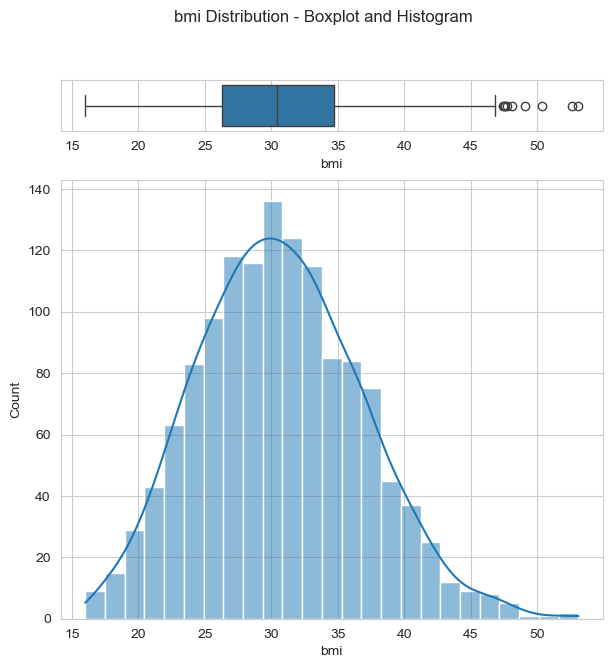

This is the range where a data point is not an outlier: from 13.7 to 47.3




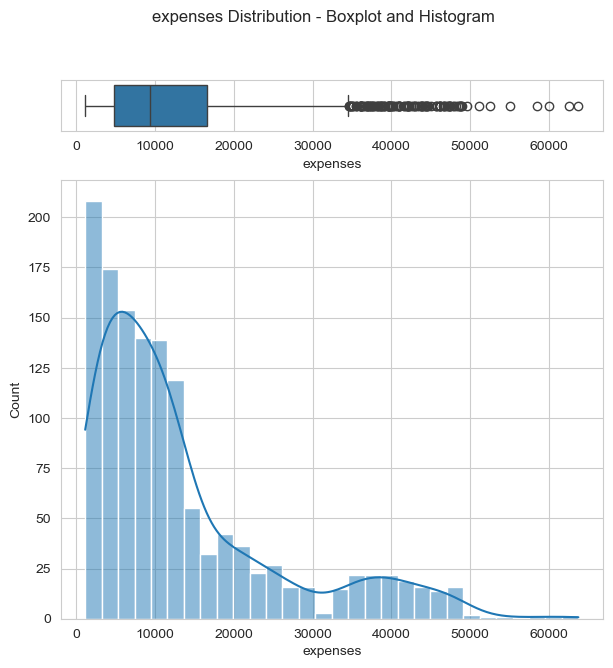

This is the range where a data point is not an outlier: from -13109.15 to 34489.36




 ========= After Transformation =========


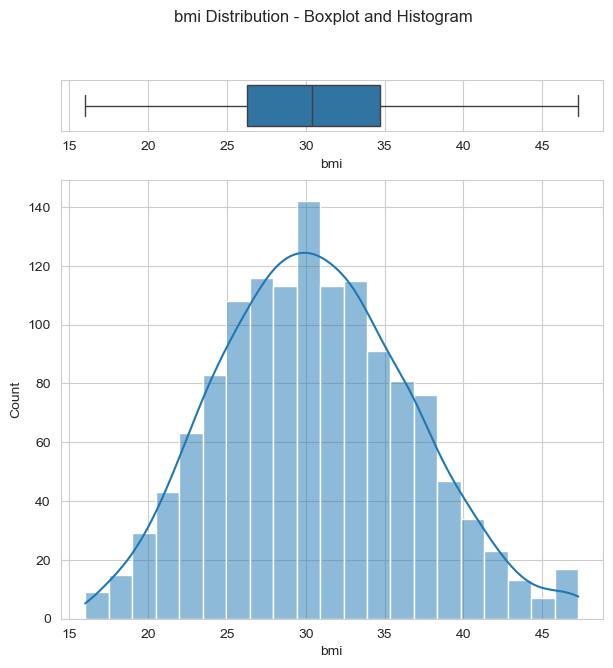

This is the range where a data point is not an outlier: from 13.7 to 47.3




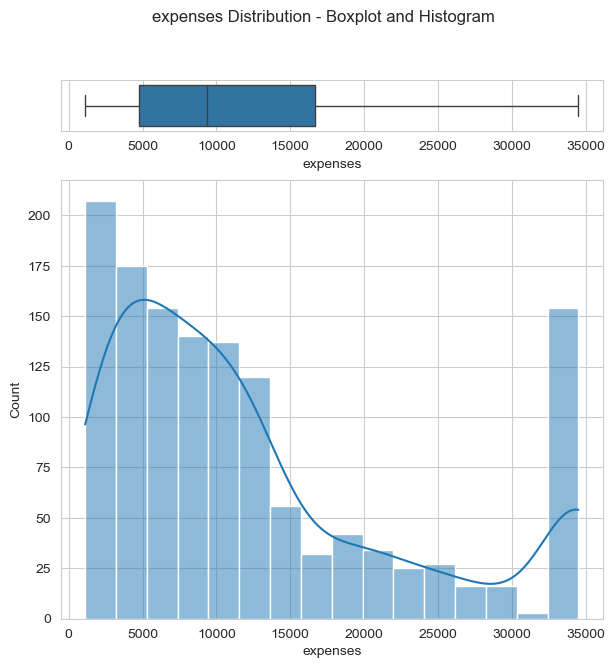

This is the range where a data point is not an outlier: from -13109.15 to 34489.36




In [43]:
print("========= Before Transformation ========= \n")
plot_histogram_and_boxplot(df)
print("\n\n ========= After Transformation =========")
plot_histogram_and_boxplot(df=df_transformed)

### Arbitrary Outlier Capper

**What it does:**
* Caps outliers using manually specified thresholds.

**How it works:**
* You define custom min and max limits (e.g., min=0, max=100).
* Values below the min are replaced with the min.
* Values above the max are replaced with the max.
**Example:** For a variable like income, you might cap values:
* Below $10,000 → replaced with $10,000
* Above $100,000 → replaced with $100,000

**Pros:**
* Useful when you have domain knowledge.
* Simple and intuitive.

**Cons:**
* Requires manual input and understanding of reasonable ranges.
* Not adaptive to different datasets.


It caps a variable's maximum or minimum values at an arbitrary value indicated by the user. The function documentation is found [here](https://feature-engine.trainindata.com/en/latest/user_guide/outliers/ArbitraryOutlierCapper.html)
* The arguments are `max_capping_dict` and `min_capping_dict`, where you parse in a dictionary of the variables and limits (min and max) you want to cap.

In [46]:
from feature_engine.outliers import ArbitraryOutlierCapper

We will consider the 'insurance' dataset, which contains information on the relationship between personal attributes (age, gender, BMI: body mass index, family size, smoking habits), geographic factors, and their impact on medical insurance charges. We will consider the variables `bmi` and `expenses`

In [49]:
df = pd.read_csv('insurance.csv').filter(['bmi', 'expenses'])
print(df.shape)
df.head()

(1338, 2)


,bmi,expenses
0,27.9,16884.92
1,33.8,1725.55
2,33.0,4449.46
3,22.7,21984.47
4,28.9,3866.86


We create a pipeline with two steps: ``DropMissingData()`` (since there should be no missing data), then ``ArbitraryOutlierCapper()``, and set 40 as the max cap for bmi and 20000 as the max cap for charges. We use these numbers so you can clearly see the effect in the histograms. In the workplace, you should reflect on the selected number for the cap.

In [53]:
from feature_engine.imputation import DropMissingData
pipeline = Pipeline([
      ( 'drop_na', DropMissingData() ),
      ( 'arb', ArbitraryOutlierCapper(max_capping_dict={'expenses':20000 , 'bmi':40}) )
])

df_transformed = pipeline.fit_transform(df)
df_transformed.head()

,bmi,expenses
0,27.9,16884.92
1,33.8,1725.55
2,33.0,4449.46
3,22.7,20000.00
4,28.9,3866.86


After applying the Arbitrary Outlier Capper method, we shouldn't have outliers.
* For each variable, we check the histogram and boxplot, before and after the transformation, so you can see the behaviour we described
  * Note the ranges have changed
  * Note after applying the transformation, all outliers values became 40 for bmi and 20000 for charges. We note a "peak" in the charges histogram around 20000 and a "peak" in the bmi histogram around 40.

========= Before Transformation ========= 



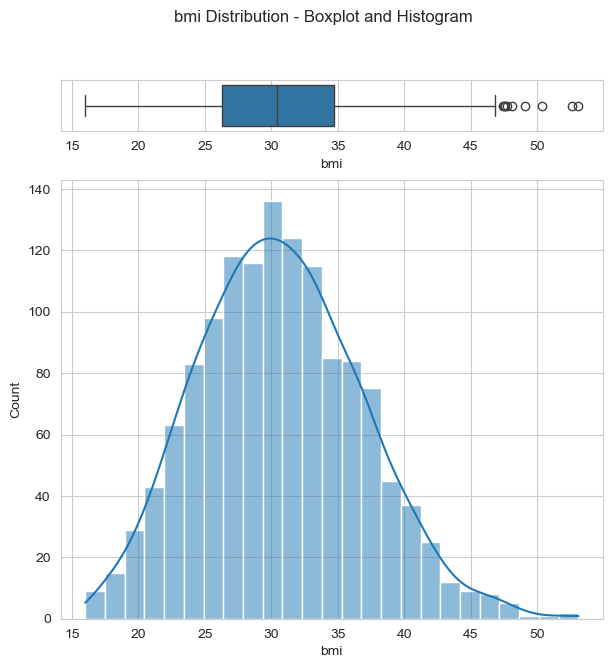

This is the range where a data point is not an outlier: from 13.7 to 47.3




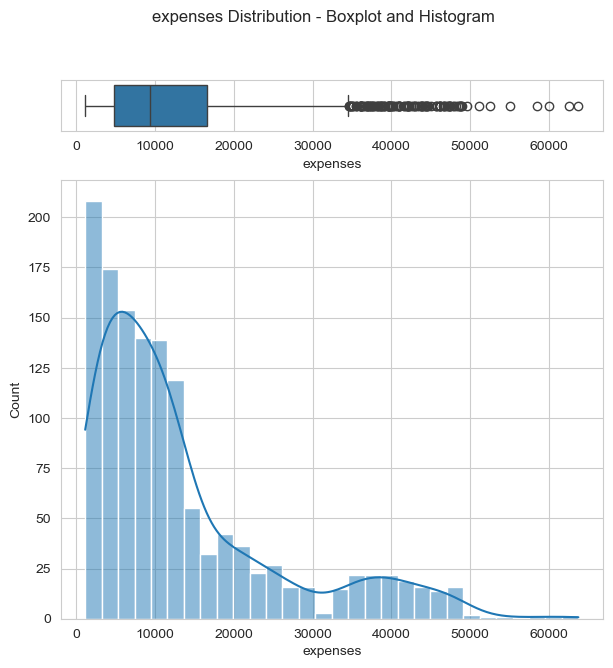

This is the range where a data point is not an outlier: from -13109.15 to 34489.36




 ========= After Transformation =========


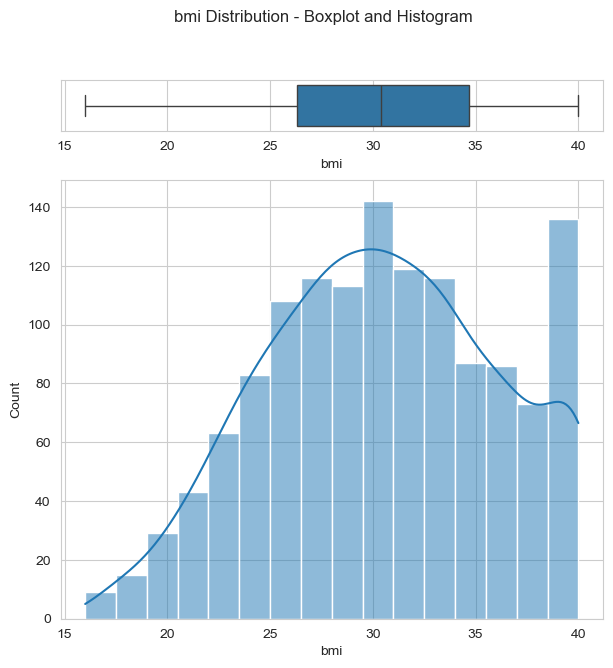

This is the range where a data point is not an outlier: from 13.7 to 47.3




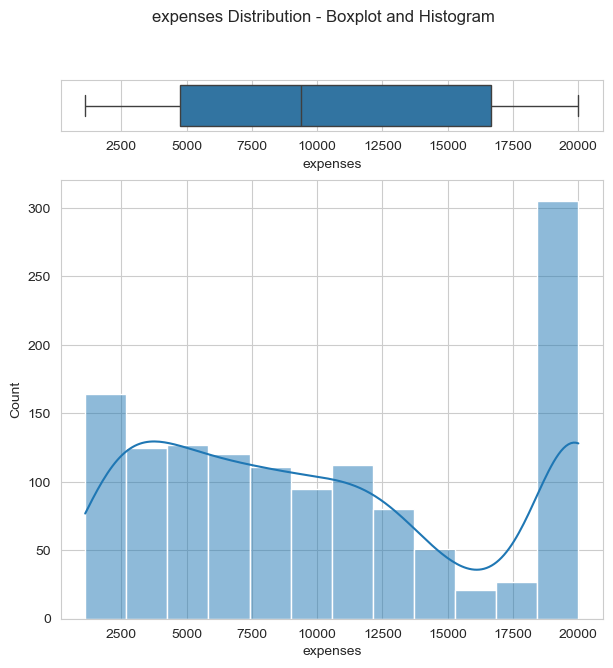

This is the range where a data point is not an outlier: from -13109.15 to 34489.36




In [59]:
print("========= Before Transformation ========= \n")
plot_histogram_and_boxplot(df)
print("\n\n ========= After Transformation =========")
plot_histogram_and_boxplot(df=df_transformed)

### Outlier Trimmer

**What it does:**
* Removes (trims) rows with outliers instead of modifying values.

**How it works:**
* Detect outliers using thresholds (e.g., IQR or quantiles).
* Drop rows with values outside the thresholds.
**Example (IQR method):**
* Lower limit = Q1 – 1.5 × IQR
* Upper limit = Q3 + 1.5 × IQR
* Any row with values outside this range is dropped.

**Pros:**
* Completely removes extreme outliers.
* Keeps the rest of the data intact.

**Cons:**
* Can result in data loss, especially if many outliers exist.
* Might bias the dataset if outliers are informative.


It removes observations with outliers from the data. The documentation is found [here](https://feature-engine.trainindata.com/en/latest/user_guide/outliers/OutlierTrimmer.html). The arguments are the variables you want to apply the transformer to. If you don't parse variables, it will get all numerical data. There are also `capping_method`, `tail` and `fold`, which have the same meaning as the  Winsorizer() technique. We will consider capping_method='irq', tail='both' and fold=1.5

In [63]:
from feature_engine.outliers import OutlierTrimmer

We will consider the 'insurance' dataset, which contains information on the relationship between personal attributes (age, gender, BMI: body mass index, family size, smoking habits), geographic factors, and their impact on medical insurance charges. We will consider the variables `bmi` and `charges`

In [65]:
df = pd.read_csv('insurance.csv').filter(['bmi', 'expenses'])
print(df.shape)
df.head()

(1338, 2)


,bmi,expenses
0,27.9,16884.92
1,33.8,1725.55
2,33.0,4449.46
3,22.7,21984.47
4,28.9,3866.86


We will assess the distribution of the variables with a custom function by plotting a combined histogram and a boxplot. In addition, we will calculate how many rows the dataset has when it includes outliers.

* The dataset has 1338 rows, considering outliers.




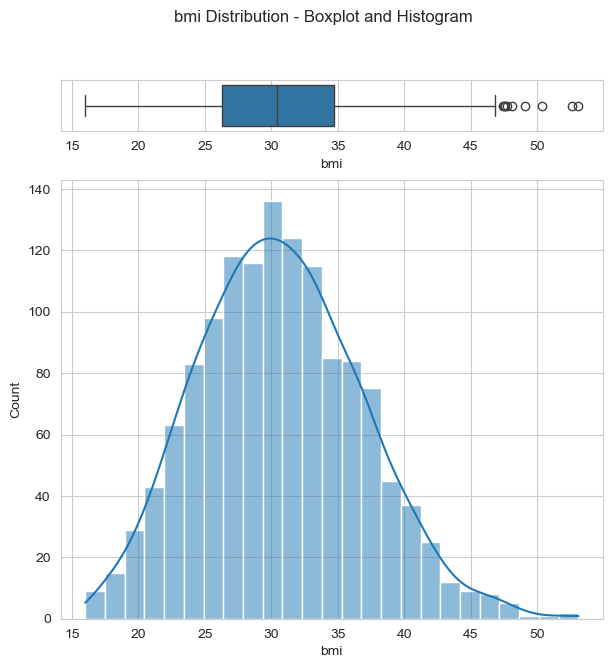

This is the range where a data point is not an outlier: from 13.7 to 47.3




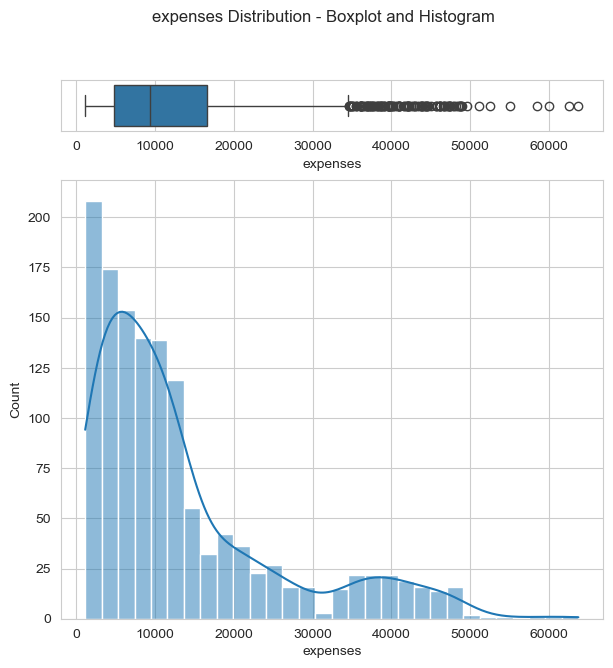

This is the range where a data point is not an outlier: from -13109.15 to 34489.36




In [69]:
print(f"* The dataset has {len(df)} rows, considering outliers.\n\n")
plot_histogram_and_boxplot(df)

We create a pipeline with two steps: `DropMissingData()` (since there should be no missing data), then `OutlierTrimmer()`, where capping_method='iqr', fold=1.5, tail='both', and variables=['bmi', 'expenses']. We `.fit_transform()` the data

In [72]:
from feature_engine.imputation import DropMissingData
pipeline = Pipeline([
      ( 'drop_na', DropMissingData() ),
      ( 'out_trimmer', OutlierTrimmer(capping_method='iqr', fold=1.5, tail='both', variables=['bmi', 'expenses']) )
])

df_transformed = pipeline.fit_transform(df)
df_transformed.head()

,bmi,expenses
0,27.9,16884.92
1,33.8,1725.55
2,33.0,4449.46
3,22.7,21984.47
4,28.9,3866.86


We notice the dataset length has decreased since we removed the observations from both variables, which were considered outliers.

In [77]:
print(f"* The dataset has {len(df)} rows, considering outliers.")
print(f"* Once it is transformed with OutlierTrimmer, dataset has {len(df_transformed)} rows")

* The dataset has 1338 rows, considering outliers.
* Once it is transformed with OutlierTrimmer, dataset has 1193 rows


But that doesn't mean the new dataset will not have outliers. Since under the new configuration or new distribution, the data might be distributed in a way that may contain a few outliers. The difference is that now you will have fewer outliers for your model. 
* Note the range has changed, as we may expect. The distribution shape is the same in the area where there are no outliers (as we may expect as well)

Please consider this route as a last resort after carefully reflecting on why your original data had outliers in the first place.

========= Before Transformation ========= 



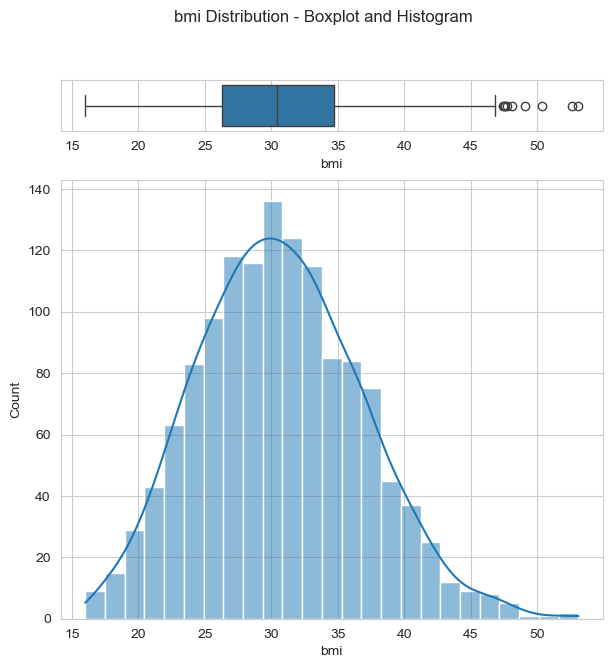

This is the range where a data point is not an outlier: from 13.7 to 47.3




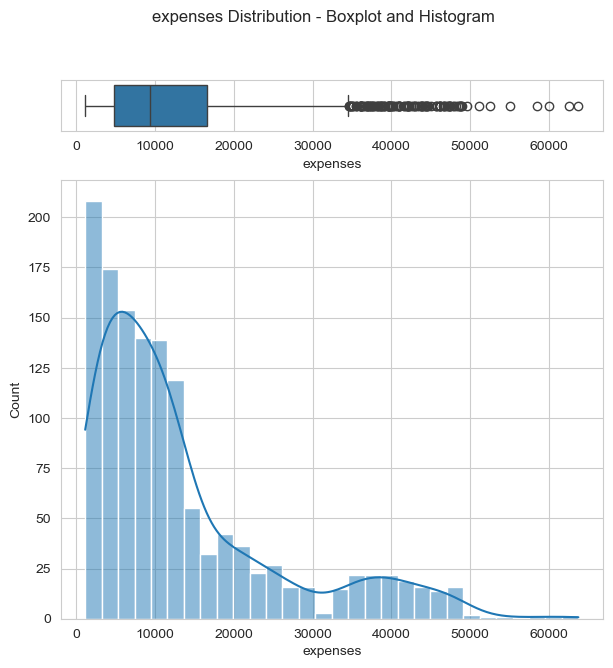

This is the range where a data point is not an outlier: from -13109.15 to 34489.36




 ========= After Transformation =========


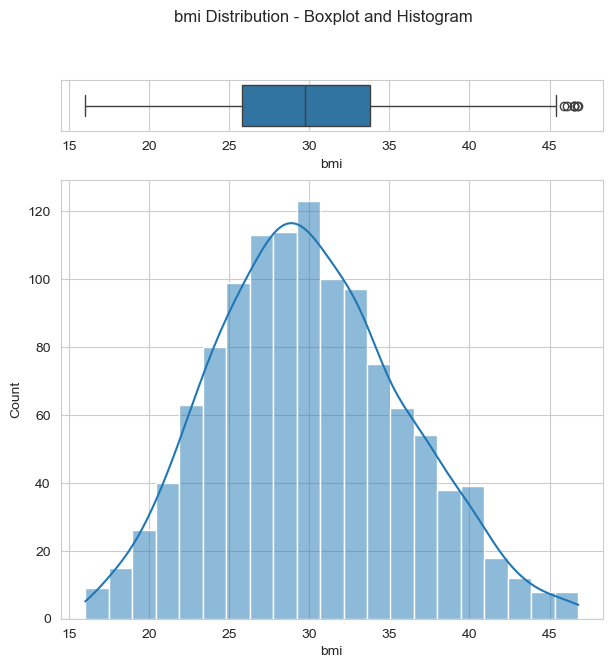

This is the range where a data point is not an outlier: from 13.8 to 45.8




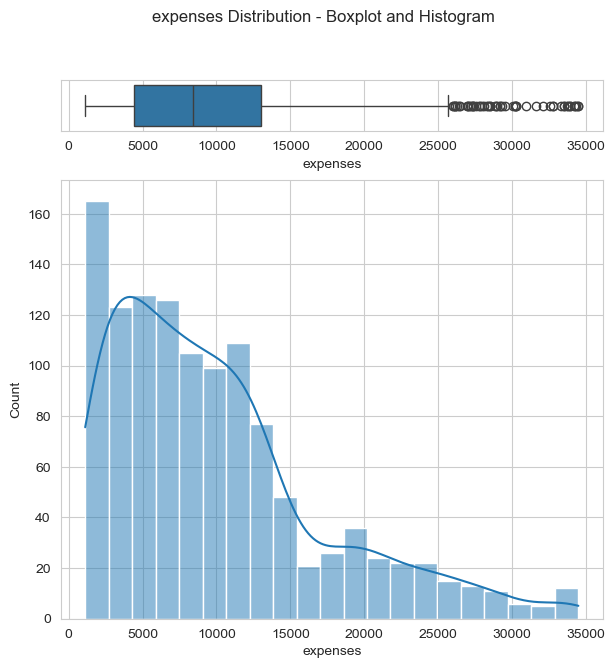

This is the range where a data point is not an outlier: from -8431.14 to 25825.66




In [81]:
print("========= Before Transformation ========= \n")
plot_histogram_and_boxplot(df)
print("\n\n ========= After Transformation =========")
plot_histogram_and_boxplot(df=df_transformed)